## Wavefunctions representation 

We are aiming to plot the wavefunctions associated to the following hamiltonian :

$$\hat{H} = 4 E_C \hat{n}^2 + \frac{E_L}{2} (\hat{\phi}-\phi_{ext})^2 - E_J \cos(\hat{\phi})$$

With the diagonalization of the hamiltonian written in the fock basis, the coefficient of the eigenvectors gives us :

$$|\psi_i\rangle = \sum^{cutoff}_{j=1} c_{ij}|j\rangle$$

With this expression, it's easy to project on the phase basis as we know the expression of the projection of the fock states on the phase basis :

$$\langle \phi \mid n \rangle
=
\frac{1}{\pi^{1/4}\sqrt{2^{n}n!}}
\frac{1}{\sqrt{\phi_{\mathrm{zpf}}}}
H_n\!\left(\frac{\phi}{\phi_{\mathrm{zpf}}}\right)
\exp\!\left[-\frac{\phi^2}{2\phi_{\mathrm{zpf}}^2}\right]
$$

Then, we will be able to plot the different wavefunctions

In [2]:
from math import factorial, pi, sqrt

import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import expm
from scipy.special import eval_hermite


In [3]:
def Hamiltonian_numpy1(flux_ext = 0, EJ=8.9, EC=2.5, EL=0.5, cutoff=110):

    n_zpf = (EL / (32 * EC)) ** 0.25
    phi_zpf = 1 / (2 * n_zpf)

    a = np.zeros((cutoff, cutoff))
    for i in range(cutoff - 1):
        a[i][i + 1] = np.sqrt(i + 1)
    a_dag = a.conj().transpose()

    phi_op = phi_zpf * (a + a_dag)
    n_op = (1j / (2 * phi_zpf)) * (a_dag - a)

    H_C = 4 * EC * (n_op @ n_op)

    phi = phi_op + flux_ext * np.eye(cutoff)
    H_L = 0.5 * EL * (phi_op @ phi_op)

    exp_i_phi = expm(1j * phi)
    cos_phi = 0.5 * (exp_i_phi + exp_i_phi.conj().T)
    H_J = -EJ * cos_phi

    return H_C + H_L + H_J

In [4]:
def Hamiltonian_numpy(flux_ext = 0, EJ=8.9, EC=2.5, EL=0.5, cutoff=110):

    n_zpf = (EL / (32 * EC)) ** 0.25
    phi_zpf = 1 / (2 * n_zpf)

    a = np.zeros((cutoff, cutoff))
    for i in range(cutoff - 1):
        a[i][i + 1] = np.sqrt(i + 1)
    a_dag = a.conj().transpose()

    phi_op = phi_zpf * (a + a_dag)
    n_op = (1j * n_zpf) * (a_dag - a)

    H_C = 4 * EC * (n_op @ n_op)

    phi = phi_op + flux_ext * np.eye(cutoff)
    H_L = 0.5 * EL * (phi_op @ phi_op)

    exp_i_phi = expm(1j * phi)
    cos_phi = 0.5 * (exp_i_phi + exp_i_phi.conj().T)
    H_J = -EJ * cos_phi

    return H_C + H_L + H_J

In [5]:
def potential(phi, flux_ext = 0,EL = 0.5,EJ=8.9):
    return EL/2 * (phi-flux_ext)**2 - EJ * np.cos(phi)

In [6]:
def eigen_vectors_numpy(N_eigen, flux_ext = 0, EJ=8.9, EC=2.5, EL=0.5, cutoff=110):
    H = Hamiltonian_numpy(flux_ext, EJ, EC, EL, cutoff)

    eigvals, eigvecs = np.linalg.eigh(H)

    return eigvecs[:, :N_eigen], eigvals[:N_eigen]

In [7]:
def fock_phase_projection(n, phi, phi_zpf=1):
    x = (phi/phi_zpf)/np.sqrt(2)
    norm = 1/(pi**0.25*sqrt(2**n*factorial(n))*np.sqrt(phi_zpf))
    return norm * eval_hermite(n, x) * np.exp(-x**2/2)

def vector_projection(Vec,phi,phi_zpf):
    Res = 0
    for i in range(np.shape(Vec)[0]):
        Res += Vec[i] * fock_phase_projection(i,phi,phi_zpf)
    return Res

In [8]:
from matplotlib.ticker import MultipleLocator

In [ ]:
def plot_wavefunctions(N_eigen, flux_ext=0, EJ=8.9, EC=2.5, EL=0.5, cutoff=110, fill_factor=0.8):

    n_zpf = (EL / (32 * EC)) ** 0.25
    phi_zpf = 1/(2*n_zpf)

    eig_vec, eigvals = eigen_vectors_numpy(N_eigen, flux_ext, EJ, EC, EL, cutoff)
    PHI = np.linspace(-3 * np.pi, 3*np.pi, 500)
    Res = np.zeros((np.shape(PHI)[0], N_eigen))
    potential_l = np.zeros(np.shape(PHI)[0])
    

    for i in range(np.shape(PHI)[0]):
        for j in range(N_eigen):
            Res[i][j] = np.abs((vector_projection(eig_vec[:,j], PHI[i]-flux_ext, phi_zpf)))**2
        potential_l[i] = potential(PHI[i], flux_ext, EL, EJ)

    if N_eigen > 1:
        avg_spacing = (eigvals[-1] - eigvals[0]) / (N_eigen - 1)
        scale = avg_spacing * fill_factor
    else:
        scale = 1.0

    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    ax.plot(PHI, potential_l, 'k-', linewidth=1, alpha=0.3, label='Potential')

    for j in range(N_eigen):
        psi_sq = Res[:, j]
        norm_factor = np.max(psi_sq) if np.max(psi_sq) > 0 else 1
        
        y_vals = eigvals[j] + (psi_sq / norm_factor) * scale
        
        ax.plot(PHI, y_vals, label=f'Energie {j}')
        ax.fill_between(PHI, eigvals[j], y_vals, alpha=0.4)

    ax.set(xlabel=r'$\phi$ [rad]', ylabel=r'Energy [GHz]')
    
    ticks = np.arange(-3, 4) * np.pi
    labels = [rf"${i}\pi$" if i != 0 else r"$0$" for i in range(-3, 4)]
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels)
    
    y_min = np.min(potential_l) - scale
    y_max = eigvals[-1] + scale * 1.5
    ax.set_ylim(y_min, y_max)

    ax.legend(title=rf"$\phi_{{\mathrm{{ext}}}} = {round(flux_ext / np.pi, 1)} \pi$")
    plt.show()

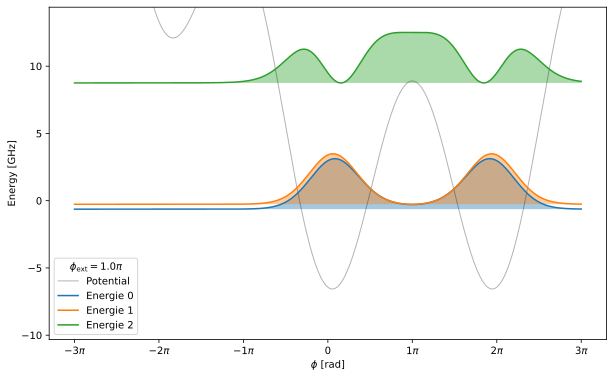

In [15]:
plot_wavefunctions(3,flux_ext = np.pi,cutoff = 120)

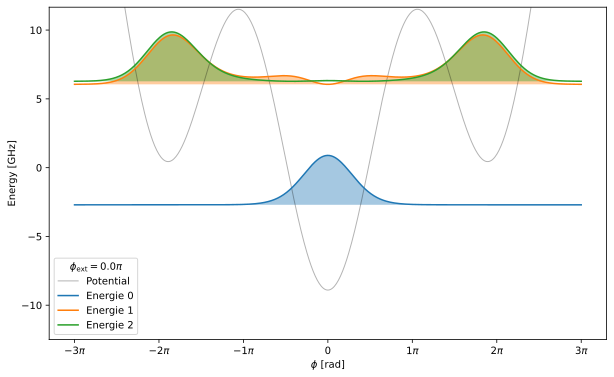

In [16]:
plot_wavefunctions(3,flux_ext = 0,cutoff = 120)

In [12]:
potential(0,np.pi/2,0.5,8.9)

-8.283149724931915

## SCQUBITS

Let's verify our results using scqubits

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='$\\varphi$', ylabel='$|$$\\psi_j(\\varphi)$$|^2$,  energy [GHz]'>)

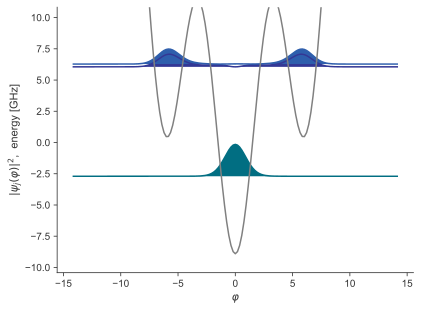

In [19]:
import scqubits

fluxonium = scqubits.Fluxonium(EJ = 8.9,
                               EC = 2.5,
                               EL = 0.5,
                               flux = 0,
                               cutoff = 110)

scqubits.Fluxonium.plot_wavefunction(fluxonium,[0,1,2],mode='abs_sqr')

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# --- CONFIGURATION STYLE SLIDE ---
base_size = 24
plt.rcParams.update({
    'font.size': base_size,
    'font.weight': 'bold',
    'axes.labelsize': base_size + 2,
    'axes.titlesize': base_size + 4,
    'xtick.labelsize': base_size,
    'ytick.labelsize': base_size,
    'lines.linewidth': 6,
    'figure.figsize': (14, 10) # Format portrait/carré pour empiler les graphes
})

# --- GÉNÉRATION DES SIGNAUX ---
t = np.linspace(0, 4*np.pi, 500)

# 1. Le "Dominant" (Haute Fréquence / Grande Valeur Propre)
# C'est celui que Krylov "voit" en premier.
freq_high = 5.0
amp_high = 1.0
y_high = amp_high * np.sin(freq_high * t)

# 2. Le "Caché" (Basse Fréquence / Petite Valeur Propre)
# C'est celui qu'on cherche à isoler.
freq_low = 0.5
amp_low = 0.4 # Plus faible amplitude pour montrer qu'il est "noyé"
y_low = amp_low * np.sin(freq_low * t)

# 3. Le Signal Total (Vecteur initial)
y_total = y_high + y_low

# --- PLOT EN 3 ÉTAPES ---
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, layout='constrained')

# ÉTAPE 1 : Le Mélange (Vecteur de départ)
ax1.plot(t, y_total, color='black', alpha=0.9)
ax1.set_title(r'1. Initial Vector $|\Psi_0\rangle$ (Mixture)', pad=15, color='black')
ax1.text(0.5, 0.9, "Dominant + Hidden States", transform=ax1.transAxes, 
         ha='center', fontsize=20, color='gray', style='italic')
ax1.set_ylabel('Amplitude')
ax1.grid(True, alpha=0.3)

# ÉTAPE 2 : Identification du Dominant (Power Method)
# On montre le signal haute fréquence seul
ax2.plot(t, y_high, color='#D62728', alpha=0.9) # Rouge
ax2.set_title(r'2. Converged State $|\psi_{max}\rangle$ (High Energy)', pad=15, color='#D62728')
ax2.text(0.5, 0.9, "Dominant Eigenvalue Captured", transform=ax2.transAxes, 
         ha='center', fontsize=20, color='#D62728', style='italic')
ax2.set_ylabel('Amplitude')
ax2.grid(True, alpha=0.3)

# ÉTAPE 3 : La Soustraction (Orthogonalisation)
# On montre ce qui reste (le basse fréquence)
ax3.plot(t, y_low, color='#1F77B4', alpha=0.9) # Bleu
ax3.set_title(r'3. Project & Subtract $\rightarrow$ Reveal $|\psi_{target}\rangle$', pad=15, color='#1F77B4')
ax3.text(0.5, 0.9, "Residual Space contains the Target", transform=ax3.transAxes, 
         ha='center', fontsize=20, color='#1F77B4', style='italic')
ax3.set_xlabel('Time (arb. units)')
ax3.set_ylabel('Amplitude')
ax3.grid(True, alpha=0.3)

# On retire les cadres inutiles pour faire propre
for ax in [ax1, ax2, ax3]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.show()

ImportError: cannot import name 'inv' from 'numpy.linalg' (unknown location)